In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [ ]:
n_variate = 1

In [ ]:

#Load dataset
def load_dataset(path=r'dataset_test_v3.csv'):
  return pd.read_csv(path)

In [ ]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [ ]:
def prepare_data(df):
  df_aux = df.drop(columns=['nr_ruas_afetadas', 'comprimento_fila_metros', 'demora_fila_segundos'], inplace=False)
  df_aux["data"] = pd.to_datetime(df_aux["data"])
  df_aux = df_aux.sort_values('data')
  df_aux = df_aux.set_index('data')

  return df_aux

In [ ]:
def data_normalization(df, norm_range=(-1, 1)):
    #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
    scaler = MinMaxScaler(feature_range=norm_range)
    #df[['cases']] = scaler.fit_transform(df[['cases']])
    # df[['nr_ruas_afetadas']] = scaler.fit_transform(df[['nr_ruas_afetadas']])
    df[['Nr_acidentes']] = scaler.fit_transform(df[['Nr_acidentes']])
    # df[['comprimento_fila_metros']] = scaler.fit_transform(df[['comprimento_fila_metros']])
    # df[['demora_fila_segundos']] = scaler.fit_transform(df[['demora_fila_segundos']])

    return scaler

In [ ]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  mae=history.history['mae']
  val_mae=history.history['val_mae']
  rmse=history.history['rmse']
  val_rmse=history.history['val_rmse']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  # plt.plot(epochs_range,mae,label='Training MAE')
  # plt.plot(epochs_range,val_mae,label='Validation MAE')
  # plt.plot(epochs_range,rmse,label='Training RMSE')
  # plt.plot(epochs_range,val_rmse,label='Validation RMSE')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [ ]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [ ]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 0])
  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [ ]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [ ]:
# 1 LSTM, 2 Densas
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features)))
    #

    model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
    model.add(tf.keras.layers.Dense(n_variate, activation='linear'))

    #model summary (and save it as PNG)
    tf.keras.utils.plot_model(model, 'accidents_model.png', show_shapes=True)
    model.summary()
    return model

In [ ]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [ ]:
#Main Execution
#the dataframes
df_raw = load_dataset()
df_data = prepare_data(df_raw)
df = df_data.copy()

scaler = data_normalization(df) #scaling data to [-1, 1]

In [ ]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    #preparar novo input para fazer previsão para o dia seguinte
    inp= np.append(inp[0],[[yhat[0][0]]],axis=0) #adiciona previsão recente ao input
    inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
  return forecasts



In [ ]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(14,6))
  plt.plot(range(len(data)), data['Nr_acidentes'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Nr de Acidentes em Braga')
  plt.ylabel('Value')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

# Tunning

In [ ]:
'''tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 100, 'cv_splits': 10, 'epochs' : 10,  'batch_size' : 4 },
                2: {'timesteps' : 7, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 50,  'batch_size' : 4 },
                3: {'timesteps' : 7, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 100,  'batch_size' : 4 },

                #
                4: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits': 10, 'epochs' : 10,  'batch_size' : 2 },
                5: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 50,  'batch_size' : 2 },
                6: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 100,  'batch_size' : 2 }#,
                #
                #7: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits': 5, 'epochs' : 10,  'batch_size' : 1 },
                #8: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits' : 5, 'epochs' : 50,  'batch_size' : 1 },
                #9: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits' : 5, 'epochs' : 100,  'batch_size' : 1 }

                }'''

tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 },
                2: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                3: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                #
                4: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                5: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                6: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                #
                7: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                8: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                9: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

}

# record da history de cada modelo
record = {}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
16/16 [==============================] - 3s 43ms/step - loss: 0.2973 - mae: 0.2595 - rmse: 0.2974 - val_loss: 0.2976 - val_mae: 0.2585 - val_rmse: 0.2825
Epoch 2/10
16/16 [==============================] - 0s 9ms/step - loss: 0.2566 - mae: 0.2112 - rmse: 0.2567 - val_loss: 0.4129 - val_mae: 0.3654 - val_rmse: 0.3937
Epoch 3/10
16/16 [==============================] - 0

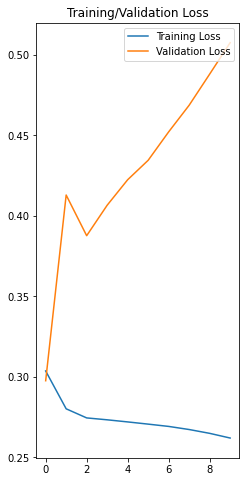

Epoch 1/10
31/31 [==============================] - 1s 9ms/step - loss: 0.3396 - mae: 0.2932 - rmse: 0.3396 - val_loss: 0.2284 - val_mae: 0.1951 - val_rmse: 0.2331
Epoch 2/10
31/31 [==============================] - 0s 6ms/step - loss: 0.3229 - mae: 0.2770 - rmse: 0.3229 - val_loss: 0.2219 - val_mae: 0.1959 - val_rmse: 0.2160
Epoch 3/10
31/31 [==============================] - 0s 7ms/step - loss: 0.3080 - mae: 0.2650 - rmse: 0.3080 - val_loss: 0.2237 - val_mae: 0.1867 - val_rmse: 0.2237
Epoch 4/10
31/31 [==============================] - 0s 6ms/step - loss: 0.3002 - mae: 0.2549 - rmse: 0.3002 - val_loss: 0.2196 - val_mae: 0.1819 - val_rmse: 0.2242
Epoch 5/10
31/31 [==============================] - 0s 7ms/step - loss: 0.2986 - mae: 0.2514 - rmse: 0.2986 - val_loss: 0.2151 - val_mae: 0.1784 - val_rmse: 0.2203

Epoch 00005: val_loss improved from 0.42238 to 0.21508, saving model to my_model_5_0.215.h5
Epoch 6/10
31/31 [==============================] - 0s 7ms/step - loss: 0.2964 - mae: 0

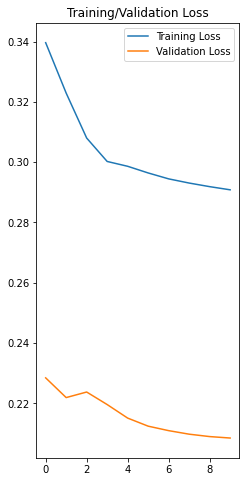

Epoch 1/10
47/47 [==============================] - 1s 17ms/step - loss: 0.2717 - mae: 0.2297 - rmse: 0.2755 - val_loss: 0.4121 - val_mae: 0.3538 - val_rmse: 0.4121
Epoch 2/10
47/47 [==============================] - 0s 6ms/step - loss: 0.2684 - mae: 0.2276 - rmse: 0.2723 - val_loss: 0.4174 - val_mae: 0.3428 - val_rmse: 0.4174
Epoch 3/10
47/47 [==============================] - 0s 6ms/step - loss: 0.2672 - mae: 0.2260 - rmse: 0.2710 - val_loss: 0.4144 - val_mae: 0.3356 - val_rmse: 0.4144
Epoch 4/10
47/47 [==============================] - 0s 6ms/step - loss: 0.2664 - mae: 0.2249 - rmse: 0.2701 - val_loss: 0.3964 - val_mae: 0.3216 - val_rmse: 0.3964
Epoch 5/10
47/47 [==============================] - 0s 6ms/step - loss: 0.2656 - mae: 0.2241 - rmse: 0.2693 - val_loss: 0.3756 - val_mae: 0.3074 - val_rmse: 0.3756

Epoch 00005: val_loss did not improve from 0.20846
Epoch 6/10
47/47 [==============================] - 0s 6ms/step - loss: 0.2644 - mae: 0.2232 - rmse: 0.2681 - val_loss: 0.3588 

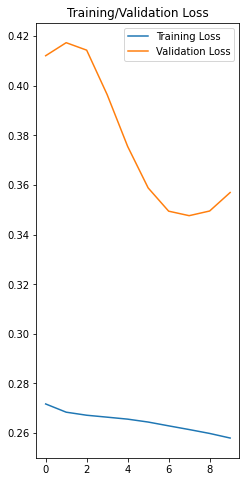

[array([[137.78076]], dtype=float32), array([[231.90338]], dtype=float32), array([[239.8142]], dtype=float32), array([[175.12418]], dtype=float32), array([[207.18024]], dtype=float32), array([[234.37608]], dtype=float32), array([[162.0652]], dtype=float32), array([[176.45007]], dtype=float32), array([[204.24554]], dtype=float32), array([[206.34781]], dtype=float32), array([[196.47813]], dtype=float32), array([[203.54684]], dtype=float32), array([[202.31483]], dtype=float32), array([[183.52354]], dtype=float32), array([[187.61346]], dtype=float32)]
[137.78076, 231.90338, 239.8142, 175.12418, 207.18024, 234.37608, 162.0652, 176.45007, 204.24554, 206.34781, 196.47813, 203.54684, 202.31483, 183.52354, 187.61346]


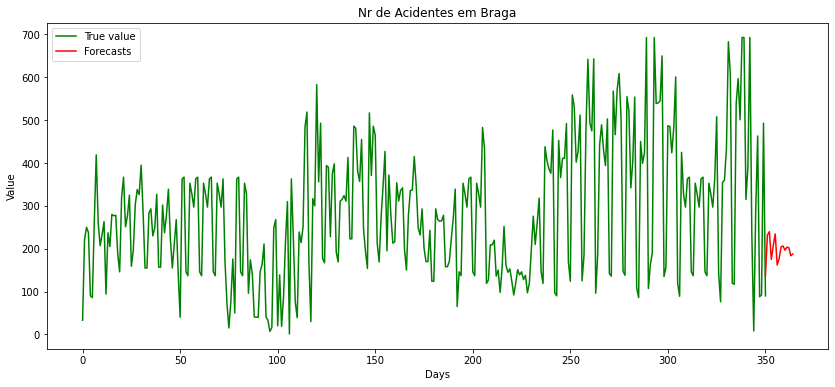

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
16/16 [==============================] - 3s 45ms/step - loss: 0.2894 - mae: 0.2522 - rmse: 0.2894 - val_loss: 0.2885 - val_mae: 0.2536 - val_rmse: 0.2750
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.2583 - mae: 0.2113 - rmse: 0.2584 - val_loss: 0.4057 - val_mae: 0.3558 - val_rmse: 0.3862
Epoch 3/50
16/16 [==============================] -

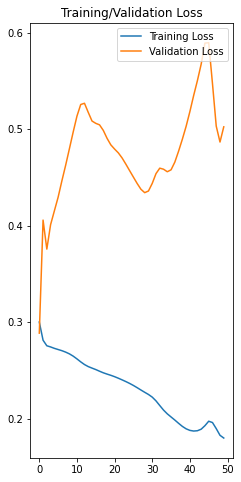

Epoch 1/50
31/31 [==============================] - 1s 9ms/step - loss: 0.3667 - mae: 0.3000 - rmse: 0.3667 - val_loss: 0.2059 - val_mae: 0.1882 - val_rmse: 0.2055
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.3083 - mae: 0.2564 - rmse: 0.3083 - val_loss: 0.2098 - val_mae: 0.1836 - val_rmse: 0.2088
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.2828 - mae: 0.2356 - rmse: 0.2828 - val_loss: 0.2118 - val_mae: 0.1713 - val_rmse: 0.2217
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.2793 - mae: 0.2355 - rmse: 0.2793 - val_loss: 0.2050 - val_mae: 0.1675 - val_rmse: 0.2167
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.2775 - mae: 0.2332 - rmse: 0.2775 - val_loss: 0.2052 - val_mae: 0.1684 - val_rmse: 0.2159

Epoch 00005: val_loss improved from 0.41518 to 0.20519, saving model to my_model_5_0.205.h5
Epoch 6/50
31/31 [==============================] - 0s 6ms/step - loss: 0.2761 - mae: 0

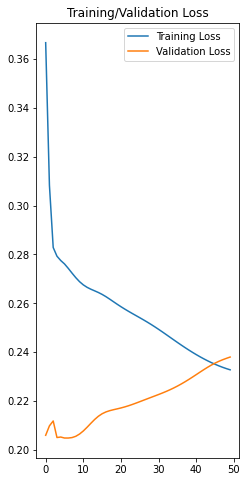

Epoch 1/50
47/47 [==============================] - 1s 17ms/step - loss: 0.2312 - mae: 0.1938 - rmse: 0.2348 - val_loss: 0.4410 - val_mae: 0.3665 - val_rmse: 0.4410
Epoch 2/50
47/47 [==============================] - 0s 7ms/step - loss: 0.2293 - mae: 0.1920 - rmse: 0.2330 - val_loss: 0.4309 - val_mae: 0.3585 - val_rmse: 0.4309
Epoch 3/50
47/47 [==============================] - 0s 7ms/step - loss: 0.2333 - mae: 0.1971 - rmse: 0.2372 - val_loss: 0.4126 - val_mae: 0.3611 - val_rmse: 0.4126
Epoch 4/50
47/47 [==============================] - 0s 7ms/step - loss: 0.2408 - mae: 0.2053 - rmse: 0.2449 - val_loss: 0.3896 - val_mae: 0.3439 - val_rmse: 0.3896
Epoch 5/50
47/47 [==============================] - 0s 6ms/step - loss: 0.2318 - mae: 0.1930 - rmse: 0.2353 - val_loss: 0.3623 - val_mae: 0.2923 - val_rmse: 0.3623

Epoch 00005: val_loss did not improve from 0.20519
Epoch 6/50
47/47 [==============================] - 0s 7ms/step - loss: 0.2340 - mae: 0.1976 - rmse: 0.2379 - val_loss: 0.3892 

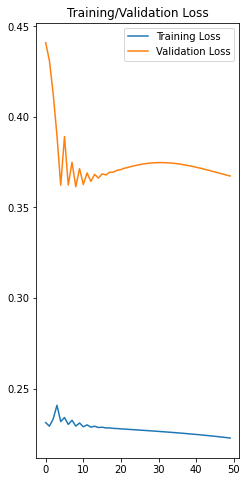

[array([[-25.316284]], dtype=float32), array([[134.61827]], dtype=float32), array([[205.12163]], dtype=float32), array([[174.11156]], dtype=float32), array([[205.76512]], dtype=float32), array([[215.46477]], dtype=float32), array([[138.00497]], dtype=float32), array([[134.00975]], dtype=float32), array([[198.06378]], dtype=float32), array([[232.11516]], dtype=float32), array([[219.16092]], dtype=float32), array([[221.07162]], dtype=float32), array([[226.22266]], dtype=float32), array([[210.4139]], dtype=float32), array([[196.52534]], dtype=float32)]
[-25.316284, 134.61827, 205.12163, 174.11156, 205.76512, 215.46477, 138.00497, 134.00975, 198.06378, 232.11516, 219.16092, 221.07162, 226.22266, 210.4139, 196.52534]


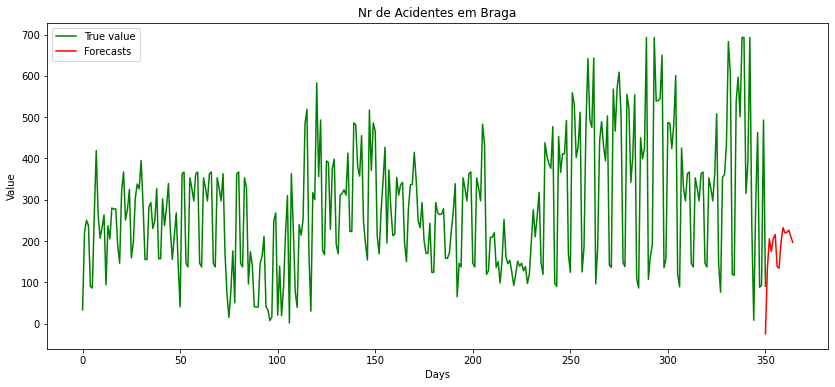

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 3s 43ms/step - loss: 0.2953 - mae: 0.2580 - rmse: 0.2954 - val_loss: 0.2907 - val_mae: 0.2563 - val_rmse: 0.2761
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.2593 - mae: 0.2124 - rmse: 0.2594 - val_loss: 0.4158 - val_mae: 0.3679 - val_rmse: 0.3948
Epoch 3/100
16/16 [==============================

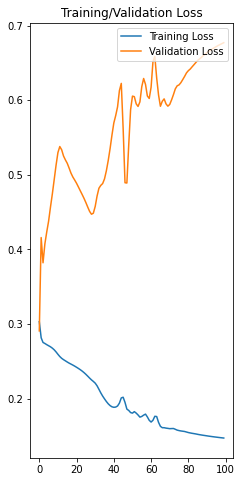

Epoch 1/100
31/31 [==============================] - 1s 9ms/step - loss: 0.3855 - mae: 0.3277 - rmse: 0.3855 - val_loss: 0.2450 - val_mae: 0.2224 - val_rmse: 0.2395
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.3096 - mae: 0.2625 - rmse: 0.3096 - val_loss: 0.2165 - val_mae: 0.1860 - val_rmse: 0.2283
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.2814 - mae: 0.2376 - rmse: 0.2814 - val_loss: 0.2063 - val_mae: 0.1779 - val_rmse: 0.2140
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.2783 - mae: 0.2321 - rmse: 0.2783 - val_loss: 0.2071 - val_mae: 0.1787 - val_rmse: 0.2122
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.2766 - mae: 0.2310 - rmse: 0.2766 - val_loss: 0.2078 - val_mae: 0.1804 - val_rmse: 0.2126

Epoch 00005: val_loss improved from 0.42341 to 0.20779, saving model to my_model_5_0.208.h5
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 0.2748 - 

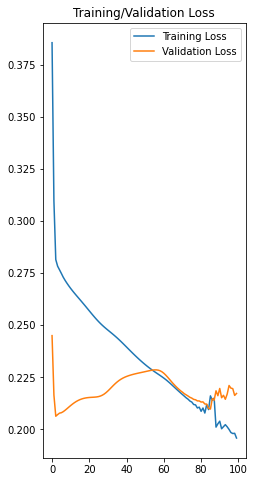

Epoch 1/100
47/47 [==============================] - 1s 18ms/step - loss: 0.2188 - mae: 0.1821 - rmse: 0.2232 - val_loss: 0.3076 - val_mae: 0.2669 - val_rmse: 0.3076
Epoch 2/100
47/47 [==============================] - 0s 8ms/step - loss: 0.2282 - mae: 0.1890 - rmse: 0.2322 - val_loss: 0.2987 - val_mae: 0.2536 - val_rmse: 0.2987
Epoch 3/100
47/47 [==============================] - 0s 9ms/step - loss: 0.2373 - mae: 0.1972 - rmse: 0.2410 - val_loss: 0.3161 - val_mae: 0.2747 - val_rmse: 0.3161
Epoch 4/100
47/47 [==============================] - 0s 8ms/step - loss: 0.2395 - mae: 0.2013 - rmse: 0.2441 - val_loss: 0.3674 - val_mae: 0.2938 - val_rmse: 0.3674
Epoch 5/100
47/47 [==============================] - 0s 8ms/step - loss: 0.2341 - mae: 0.1955 - rmse: 0.2381 - val_loss: 0.3517 - val_mae: 0.2812 - val_rmse: 0.3517

Epoch 00005: val_loss did not improve from 0.20779
Epoch 6/100
47/47 [==============================] - 0s 9ms/step - loss: 0.2286 - mae: 0.1906 - rmse: 0.2328 - val_loss: 0

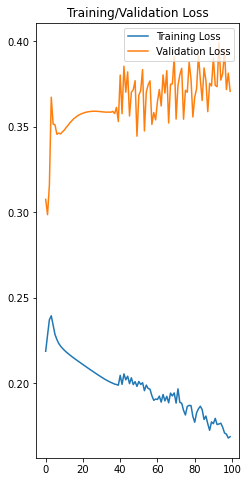

[array([[10.824896]], dtype=float32), array([[229.36725]], dtype=float32), array([[177.60765]], dtype=float32), array([[227.1797]], dtype=float32), array([[327.78278]], dtype=float32), array([[436.04282]], dtype=float32), array([[267.32956]], dtype=float32), array([[130.86287]], dtype=float32), array([[251.40292]], dtype=float32), array([[268.19244]], dtype=float32), array([[247.67769]], dtype=float32), array([[271.15726]], dtype=float32), array([[284.42484]], dtype=float32), array([[236.13287]], dtype=float32), array([[187.91586]], dtype=float32)]
[10.824896, 229.36725, 177.60765, 227.1797, 327.78278, 436.04282, 267.32956, 130.86287, 251.40292, 268.19244, 247.67769, 271.15726, 284.42484, 236.13287, 187.91586]


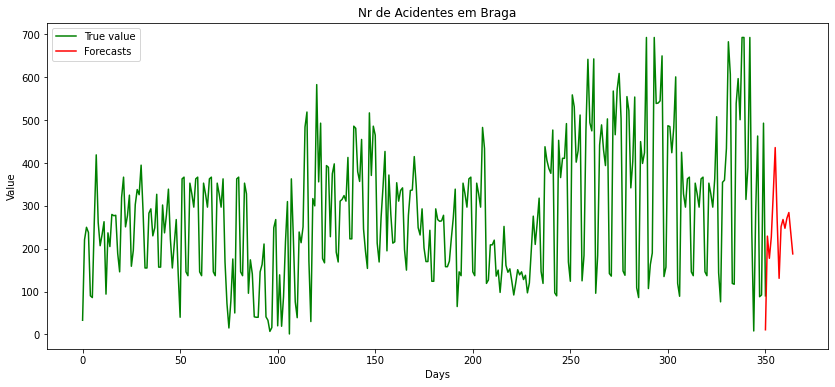

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
16/16 [==============================] - 2s 44ms/step - loss: 0.2895 - mae: 0.2547 - rmse: 0.2898 - val_loss: 0.2838 - val_mae: 0.2497 - val_rmse: 0.2722
Epoch 2/60
16/16 [==============================] - 0s 10ms/step - loss: 0.2217 - mae: 0.1926 - rmse: 0.2220 - val_loss: 0.4066 - val_mae: 0.3572 - val_rmse: 0.3881
Epoch 3/60
16/16 [==============================] 

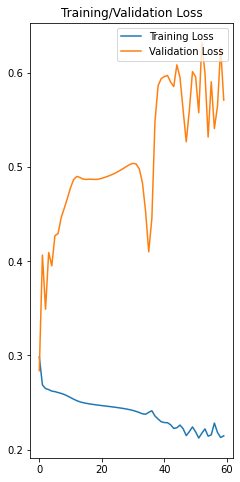

Epoch 1/60
31/31 [==============================] - 0s 12ms/step - loss: 0.3375 - mae: 0.2874 - rmse: 0.3364 - val_loss: 0.2225 - val_mae: 0.1994 - val_rmse: 0.2149
Epoch 2/60
31/31 [==============================] - 0s 9ms/step - loss: 0.3132 - mae: 0.2774 - rmse: 0.3122 - val_loss: 0.2193 - val_mae: 0.1871 - val_rmse: 0.2232
Epoch 3/60
31/31 [==============================] - 0s 10ms/step - loss: 0.2841 - mae: 0.2437 - rmse: 0.2830 - val_loss: 0.2318 - val_mae: 0.2006 - val_rmse: 0.2346
Epoch 4/60
31/31 [==============================] - 0s 10ms/step - loss: 0.2830 - mae: 0.2436 - rmse: 0.2819 - val_loss: 0.2316 - val_mae: 0.2002 - val_rmse: 0.2370
Epoch 5/60
31/31 [==============================] - 0s 9ms/step - loss: 0.2809 - mae: 0.2414 - rmse: 0.2798 - val_loss: 0.2288 - val_mae: 0.1969 - val_rmse: 0.2350

Epoch 00005: val_loss improved from 0.39508 to 0.22875, saving model to my_model_5_0.229.h5
Epoch 6/60
31/31 [==============================] - 0s 9ms/step - loss: 0.2790 - mae

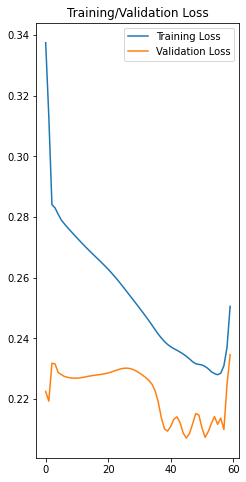

Epoch 1/60
47/47 [==============================] - 1s 19ms/step - loss: 0.2405 - mae: 0.2000 - rmse: 0.2395 - val_loss: 0.4007 - val_mae: 0.3337 - val_rmse: 0.4007
Epoch 2/60
47/47 [==============================] - 0s 8ms/step - loss: 0.2279 - mae: 0.1896 - rmse: 0.2259 - val_loss: 0.4184 - val_mae: 0.3473 - val_rmse: 0.4184
Epoch 3/60
47/47 [==============================] - 0s 8ms/step - loss: 0.2304 - mae: 0.1925 - rmse: 0.2278 - val_loss: 0.4223 - val_mae: 0.3508 - val_rmse: 0.4223
Epoch 4/60
47/47 [==============================] - 0s 8ms/step - loss: 0.2306 - mae: 0.1944 - rmse: 0.2275 - val_loss: 0.4023 - val_mae: 0.3268 - val_rmse: 0.4023
Epoch 5/60
47/47 [==============================] - 0s 8ms/step - loss: 0.2283 - mae: 0.1924 - rmse: 0.2248 - val_loss: 0.3840 - val_mae: 0.3129 - val_rmse: 0.3840

Epoch 00005: val_loss did not improve from 0.20871
Epoch 6/60
47/47 [==============================] - 0s 8ms/step - loss: 0.2265 - mae: 0.1901 - rmse: 0.2228 - val_loss: 0.3779 

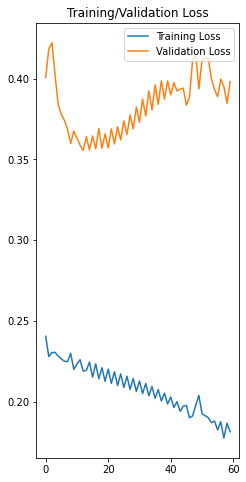

[array([[-18.81515]], dtype=float32), array([[208.49036]], dtype=float32), array([[223.59488]], dtype=float32), array([[63.18167]], dtype=float32), array([[145.81905]], dtype=float32), array([[140.92343]], dtype=float32), array([[143.39502]], dtype=float32), array([[93.409004]], dtype=float32), array([[196.23311]], dtype=float32), array([[141.49634]], dtype=float32), array([[81.17368]], dtype=float32), array([[147.7154]], dtype=float32), array([[156.63875]], dtype=float32), array([[126.83431]], dtype=float32), array([[153.94327]], dtype=float32)]
[-18.81515, 208.49036, 223.59488, 63.18167, 145.81905, 140.92343, 143.39502, 93.409004, 196.23311, 141.49634, 81.17368, 147.7154, 156.63875, 126.83431, 153.94327]


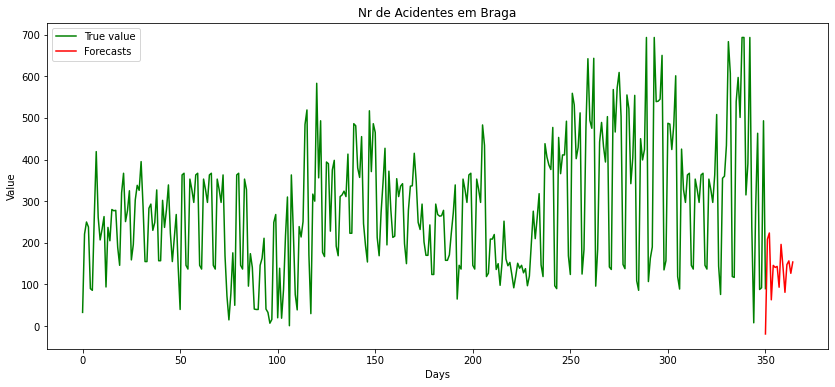

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/90
16/16 [==============================] - 3s 44ms/step - loss: 0.2947 - mae: 0.2578 - rmse: 0.2951 - val_loss: 0.2870 - val_mae: 0.2528 - val_rmse: 0.2738
Epoch 2/90
16/16 [==============================] - 0s 9ms/step - loss: 0.2221 - mae: 0.1938 - rmse: 0.2224 - val_loss: 0.4143 - val_mae: 0.3665 - val_rmse: 0.3942
Epoch 3/90
16/16 [==============================] -

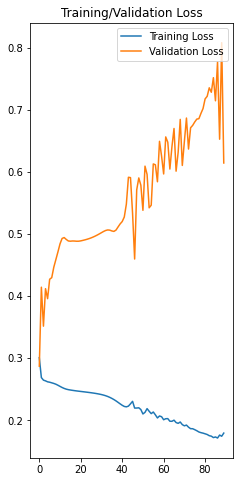

Epoch 1/90
31/31 [==============================] - 0s 10ms/step - loss: 0.3985 - mae: 0.3522 - rmse: 0.3974 - val_loss: 0.2209 - val_mae: 0.1982 - val_rmse: 0.2098
Epoch 2/90
31/31 [==============================] - 0s 8ms/step - loss: 0.3189 - mae: 0.2740 - rmse: 0.3179 - val_loss: 0.2366 - val_mae: 0.1930 - val_rmse: 0.2487
Epoch 3/90
31/31 [==============================] - 0s 9ms/step - loss: 0.2801 - mae: 0.2421 - rmse: 0.2791 - val_loss: 0.2323 - val_mae: 0.2021 - val_rmse: 0.2436
Epoch 4/90
31/31 [==============================] - 0s 8ms/step - loss: 0.2780 - mae: 0.2397 - rmse: 0.2770 - val_loss: 0.2306 - val_mae: 0.2021 - val_rmse: 0.2401
Epoch 5/90
31/31 [==============================] - 0s 8ms/step - loss: 0.2755 - mae: 0.2376 - rmse: 0.2746 - val_loss: 0.2295 - val_mae: 0.1994 - val_rmse: 0.2397

Epoch 00005: val_loss improved from 0.39579 to 0.22951, saving model to my_model_5_0.230.h5
Epoch 6/90
31/31 [==============================] - 0s 8ms/step - loss: 0.2733 - mae: 

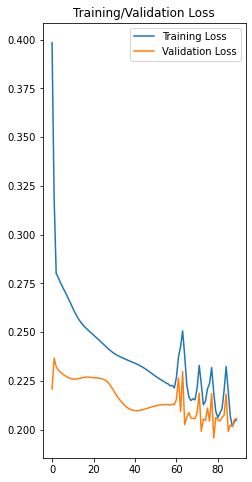

Epoch 1/90
47/47 [==============================] - 1s 19ms/step - loss: 0.2278 - mae: 0.1922 - rmse: 0.2261 - val_loss: 0.3985 - val_mae: 0.3384 - val_rmse: 0.3985
Epoch 2/90
47/47 [==============================] - 0s 9ms/step - loss: 0.2253 - mae: 0.1912 - rmse: 0.2226 - val_loss: 0.4547 - val_mae: 0.3637 - val_rmse: 0.4547
Epoch 3/90
47/47 [==============================] - 0s 9ms/step - loss: 0.2158 - mae: 0.1828 - rmse: 0.2130 - val_loss: 0.3950 - val_mae: 0.3239 - val_rmse: 0.3950
Epoch 4/90
47/47 [==============================] - 0s 9ms/step - loss: 0.2097 - mae: 0.1774 - rmse: 0.2069 - val_loss: 0.3718 - val_mae: 0.2986 - val_rmse: 0.3718
Epoch 5/90
47/47 [==============================] - 0s 9ms/step - loss: 0.2123 - mae: 0.1796 - rmse: 0.2094 - val_loss: 0.3622 - val_mae: 0.2868 - val_rmse: 0.3622

Epoch 00005: val_loss did not improve from 0.20262
Epoch 6/90
47/47 [==============================] - 0s 9ms/step - loss: 0.2102 - mae: 0.1792 - rmse: 0.2068 - val_loss: 0.3831 

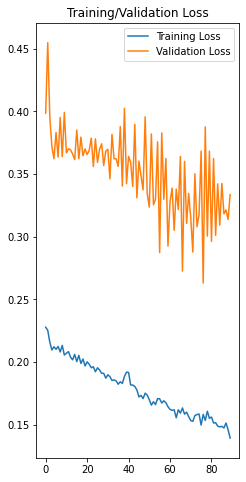

[array([[37.56701]], dtype=float32), array([[243.61398]], dtype=float32), array([[165.67752]], dtype=float32), array([[99.03117]], dtype=float32), array([[150.98611]], dtype=float32), array([[367.12552]], dtype=float32), array([[266.1948]], dtype=float32), array([[87.39172]], dtype=float32), array([[322.87604]], dtype=float32), array([[268.68527]], dtype=float32), array([[106.72019]], dtype=float32), array([[105.01754]], dtype=float32), array([[234.00597]], dtype=float32), array([[134.65163]], dtype=float32), array([[166.34103]], dtype=float32)]
[37.56701, 243.61398, 165.67752, 99.03117, 150.98611, 367.12552, 266.1948, 87.39172, 322.87604, 268.68527, 106.72019, 105.01754, 234.00597, 134.65163, 166.34103]


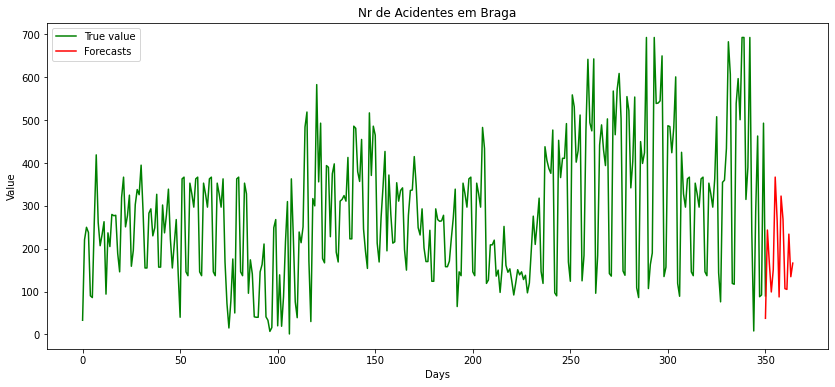

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
16/16 [==============================] - 3s 46ms/step - loss: 0.2719 - mae: 0.2384 - rmse: 0.2723 - val_loss: 0.2935 - val_mae: 0.2559 - val_rmse: 0.2802
Epoch 2/120
16/16 [==============================] - 0s 13ms/step - loss: 0.2208 - mae: 0.1896 - rmse: 0.2211 - val_loss: 0.3845 - val_mae: 0.3371 - val_rmse: 0.3656
Epoch 3/120
16/16 [=============================

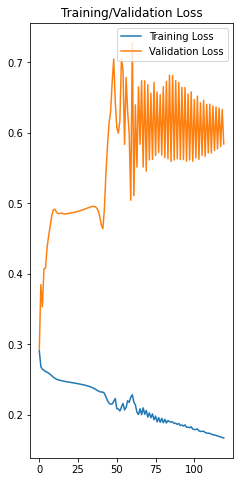

Epoch 1/120
31/31 [==============================] - 0s 11ms/step - loss: 0.3749 - mae: 0.3219 - rmse: 0.3743 - val_loss: 0.2288 - val_mae: 0.2111 - val_rmse: 0.2243
Epoch 2/120
31/31 [==============================] - 0s 9ms/step - loss: 0.2884 - mae: 0.2482 - rmse: 0.2873 - val_loss: 0.2184 - val_mae: 0.1956 - val_rmse: 0.2347
Epoch 3/120
31/31 [==============================] - 0s 9ms/step - loss: 0.2657 - mae: 0.2260 - rmse: 0.2649 - val_loss: 0.2140 - val_mae: 0.1854 - val_rmse: 0.2259
Epoch 4/120
31/31 [==============================] - 0s 9ms/step - loss: 0.2619 - mae: 0.2239 - rmse: 0.2612 - val_loss: 0.2133 - val_mae: 0.1856 - val_rmse: 0.2249
Epoch 5/120
31/31 [==============================] - 0s 9ms/step - loss: 0.2589 - mae: 0.2206 - rmse: 0.2582 - val_loss: 0.2130 - val_mae: 0.1857 - val_rmse: 0.2248

Epoch 00005: val_loss improved from 0.40809 to 0.21296, saving model to my_model_5_0.213.h5
Epoch 6/120
31/31 [==============================] - 0s 9ms/step - loss: 0.2567 -

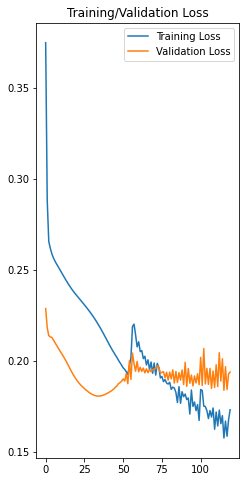

Epoch 1/120
47/47 [==============================] - 1s 19ms/step - loss: 0.1859 - mae: 0.1575 - rmse: 0.1833 - val_loss: 0.3698 - val_mae: 0.2876 - val_rmse: 0.3698
Epoch 2/120
47/47 [==============================] - 0s 8ms/step - loss: 0.1957 - mae: 0.1647 - rmse: 0.1929 - val_loss: 0.3329 - val_mae: 0.2826 - val_rmse: 0.3329
Epoch 3/120
47/47 [==============================] - 0s 7ms/step - loss: 0.1894 - mae: 0.1607 - rmse: 0.1862 - val_loss: 0.3235 - val_mae: 0.2616 - val_rmse: 0.3235
Epoch 4/120
47/47 [==============================] - 0s 8ms/step - loss: 0.1820 - mae: 0.1519 - rmse: 0.1791 - val_loss: 0.3346 - val_mae: 0.2732 - val_rmse: 0.3346
Epoch 5/120
47/47 [==============================] - 0s 8ms/step - loss: 0.1742 - mae: 0.1456 - rmse: 0.1713 - val_loss: 0.3086 - val_mae: 0.2471 - val_rmse: 0.3086

Epoch 00005: val_loss did not improve from 0.18077
Epoch 6/120
47/47 [==============================] - 0s 8ms/step - loss: 0.1797 - mae: 0.1513 - rmse: 0.1769 - val_loss: 0

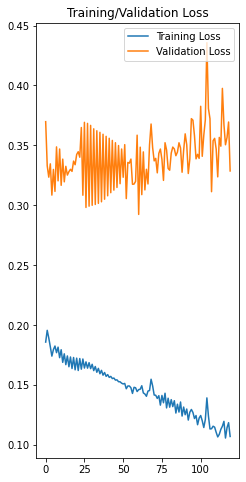

[array([[98.796295]], dtype=float32), array([[213.91458]], dtype=float32), array([[127.13589]], dtype=float32), array([[153.10023]], dtype=float32), array([[159.52005]], dtype=float32), array([[399.70416]], dtype=float32), array([[383.82312]], dtype=float32), array([[217.94182]], dtype=float32), array([[177.92136]], dtype=float32), array([[289.70126]], dtype=float32), array([[173.49298]], dtype=float32), array([[188.3644]], dtype=float32), array([[211.82692]], dtype=float32), array([[268.54477]], dtype=float32), array([[229.4787]], dtype=float32)]
[98.796295, 213.91458, 127.13589, 153.10023, 159.52005, 399.70416, 383.82312, 217.94182, 177.92136, 289.70126, 173.49298, 188.3644, 211.82692, 268.54477, 229.4787]


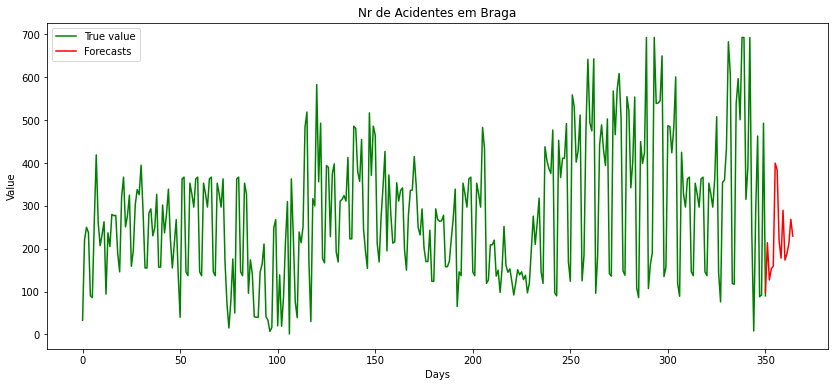

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10/10 [==============================] - 2s 72ms/step - loss: 0.3062 - mae: 0.2582 - rmse: 0.3068 - val_loss: 0.2759 - val_mae: 0.2442 - val_rmse: 0.2759
Epoch 2/50
10/10 [==============================] - 0s 16ms/step - loss: 0.2412 - mae: 0.2173 - rmse: 0.2418 - val_loss: 0.4041 - val_mae: 0.3462 - val_rmse: 0.4041
Epoch 3/50
10/10 [==============================] 

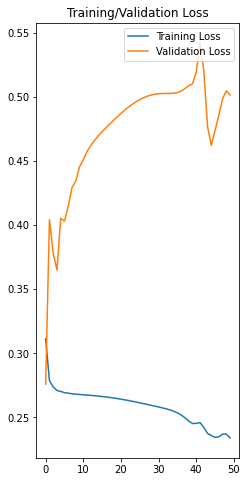

Epoch 1/50
20/20 [==============================] - 0s 14ms/step - loss: 0.3257 - mae: 0.2660 - rmse: 0.3122 - val_loss: 0.2251 - val_mae: 0.1861 - val_rmse: 0.2251
Epoch 2/50
20/20 [==============================] - 0s 11ms/step - loss: 0.3130 - mae: 0.2632 - rmse: 0.3040 - val_loss: 0.2113 - val_mae: 0.1846 - val_rmse: 0.2113
Epoch 3/50
20/20 [==============================] - 0s 11ms/step - loss: 0.3056 - mae: 0.2629 - rmse: 0.2927 - val_loss: 0.2244 - val_mae: 0.1928 - val_rmse: 0.2244
Epoch 4/50
20/20 [==============================] - 0s 12ms/step - loss: 0.2993 - mae: 0.2547 - rmse: 0.2865 - val_loss: 0.2243 - val_mae: 0.1911 - val_rmse: 0.2243
Epoch 5/50
20/20 [==============================] - 0s 13ms/step - loss: 0.2992 - mae: 0.2533 - rmse: 0.2864 - val_loss: 0.2239 - val_mae: 0.1889 - val_rmse: 0.2239

Epoch 00005: val_loss improved from 0.40526 to 0.22394, saving model to my_model_5_0.224.h5
Epoch 6/50
20/20 [==============================] - 0s 12ms/step - loss: 0.2978 - 

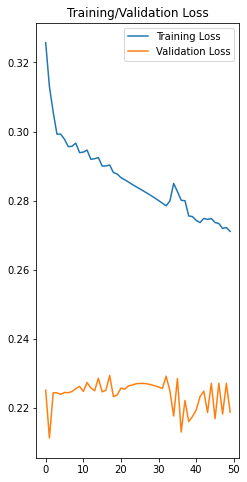

Epoch 1/50
29/29 [==============================] - 0s 12ms/step - loss: 0.2593 - mae: 0.2141 - rmse: 0.2603 - val_loss: 0.4494 - val_mae: 0.4024 - val_rmse: 0.5571
Epoch 2/50
29/29 [==============================] - 0s 11ms/step - loss: 0.2610 - mae: 0.2168 - rmse: 0.2618 - val_loss: 0.4189 - val_mae: 0.3646 - val_rmse: 0.5464
Epoch 3/50
29/29 [==============================] - 0s 12ms/step - loss: 0.2564 - mae: 0.2103 - rmse: 0.2571 - val_loss: 0.4340 - val_mae: 0.3846 - val_rmse: 0.5606
Epoch 4/50
29/29 [==============================] - 0s 11ms/step - loss: 0.2568 - mae: 0.2108 - rmse: 0.2574 - val_loss: 0.4292 - val_mae: 0.3775 - val_rmse: 0.5635
Epoch 5/50
29/29 [==============================] - 0s 11ms/step - loss: 0.2555 - mae: 0.2090 - rmse: 0.2561 - val_loss: 0.4301 - val_mae: 0.3781 - val_rmse: 0.5634

Epoch 00005: val_loss did not improve from 0.21749
Epoch 6/50
29/29 [==============================] - 0s 11ms/step - loss: 0.2550 - mae: 0.2087 - rmse: 0.2555 - val_loss: 0.

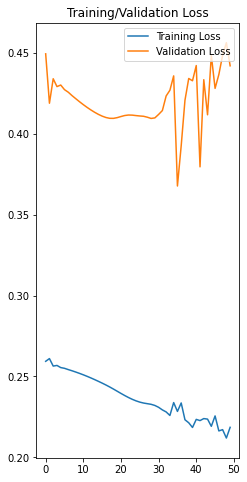

[array([[141.279]], dtype=float32), array([[375.4014]], dtype=float32), array([[323.12634]], dtype=float32), array([[280.6609]], dtype=float32), array([[216.33942]], dtype=float32), array([[252.77156]], dtype=float32), array([[241.7198]], dtype=float32), array([[239.89778]], dtype=float32), array([[291.37857]], dtype=float32), array([[252.71397]], dtype=float32), array([[319.4334]], dtype=float32), array([[220.72102]], dtype=float32), array([[188.94075]], dtype=float32), array([[244.16743]], dtype=float32), array([[267.9736]], dtype=float32)]
[141.279, 375.4014, 323.12634, 280.6609, 216.33942, 252.77156, 241.7198, 239.89778, 291.37857, 252.71397, 319.4334, 220.72102, 188.94075, 244.16743, 267.9736]


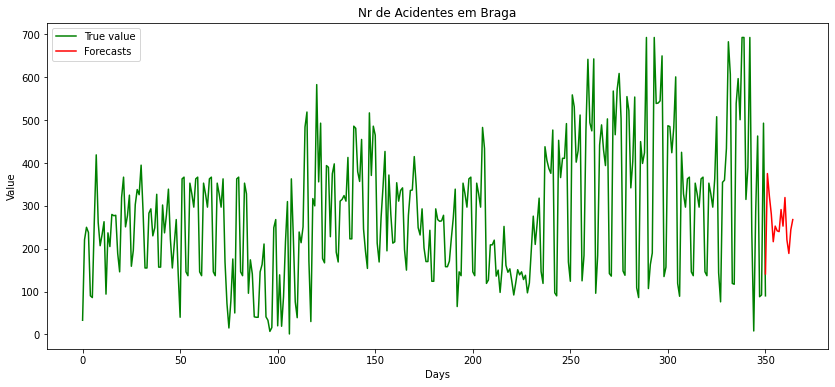

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/90
10/10 [==============================] - 2s 70ms/step - loss: 0.3261 - mae: 0.2767 - rmse: 0.3264 - val_loss: 0.2983 - val_mae: 0.2518 - val_rmse: 0.2983
Epoch 2/90
10/10 [==============================] - 0s 16ms/step - loss: 0.2397 - mae: 0.2146 - rmse: 0.2403 - val_loss: 0.3978 - val_mae: 0.3412 - val_rmse: 0.3978
Epoch 3/90
10/10 [==============================] 

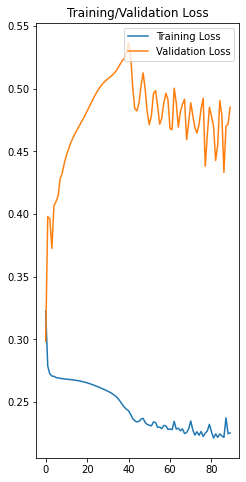

Epoch 1/90
20/20 [==============================] - 0s 14ms/step - loss: 0.3152 - mae: 0.2570 - rmse: 0.3052 - val_loss: 0.2093 - val_mae: 0.1816 - val_rmse: 0.2093
Epoch 2/90
20/20 [==============================] - 0s 11ms/step - loss: 0.3017 - mae: 0.2543 - rmse: 0.2900 - val_loss: 0.2238 - val_mae: 0.1874 - val_rmse: 0.2238
Epoch 3/90
20/20 [==============================] - 0s 12ms/step - loss: 0.2919 - mae: 0.2462 - rmse: 0.2796 - val_loss: 0.2185 - val_mae: 0.1826 - val_rmse: 0.2185
Epoch 4/90
20/20 [==============================] - 0s 12ms/step - loss: 0.2948 - mae: 0.2449 - rmse: 0.2822 - val_loss: 0.2186 - val_mae: 0.1805 - val_rmse: 0.2186
Epoch 5/90
20/20 [==============================] - 0s 11ms/step - loss: 0.2909 - mae: 0.2435 - rmse: 0.2802 - val_loss: 0.2255 - val_mae: 0.1829 - val_rmse: 0.2255

Epoch 00005: val_loss improved from 0.40667 to 0.22552, saving model to my_model_5_0.226.h5
Epoch 6/90
20/20 [==============================] - 0s 10ms/step - loss: 0.2893 - 

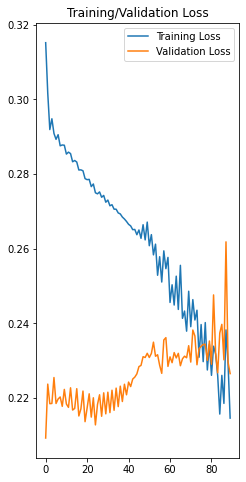

Epoch 1/90
29/29 [==============================] - 0s 13ms/step - loss: 0.2252 - mae: 0.1883 - rmse: 0.2249 - val_loss: 0.4203 - val_mae: 0.3628 - val_rmse: 0.4247
Epoch 2/90
29/29 [==============================] - 0s 11ms/step - loss: 0.2212 - mae: 0.1850 - rmse: 0.2208 - val_loss: 0.4170 - val_mae: 0.3526 - val_rmse: 0.4342
Epoch 3/90
29/29 [==============================] - 0s 11ms/step - loss: 0.2188 - mae: 0.1815 - rmse: 0.2184 - val_loss: 0.4240 - val_mae: 0.3500 - val_rmse: 0.4444
Epoch 4/90
29/29 [==============================] - 0s 11ms/step - loss: 0.2146 - mae: 0.1773 - rmse: 0.2142 - val_loss: 0.4105 - val_mae: 0.3450 - val_rmse: 0.4225
Epoch 5/90
29/29 [==============================] - 0s 11ms/step - loss: 0.2145 - mae: 0.1780 - rmse: 0.2142 - val_loss: 0.4152 - val_mae: 0.3292 - val_rmse: 0.4337

Epoch 00005: val_loss did not improve from 0.21283
Epoch 6/90
29/29 [==============================] - 0s 11ms/step - loss: 0.2169 - mae: 0.1778 - rmse: 0.2165 - val_loss: 0.

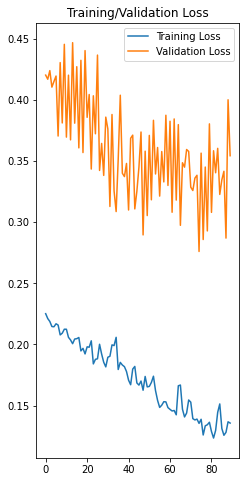

[array([[162.17612]], dtype=float32), array([[279.65845]], dtype=float32), array([[257.14355]], dtype=float32), array([[313.8971]], dtype=float32), array([[350.44083]], dtype=float32), array([[356.7177]], dtype=float32), array([[109.04294]], dtype=float32), array([[115.92787]], dtype=float32), array([[320.58636]], dtype=float32), array([[301.0227]], dtype=float32), array([[297.99927]], dtype=float32), array([[365.9828]], dtype=float32), array([[363.11935]], dtype=float32), array([[194.62024]], dtype=float32), array([[169.36978]], dtype=float32)]
[162.17612, 279.65845, 257.14355, 313.8971, 350.44083, 356.7177, 109.04294, 115.92787, 320.58636, 301.0227, 297.99927, 365.9828, 363.11935, 194.62024, 169.36978]


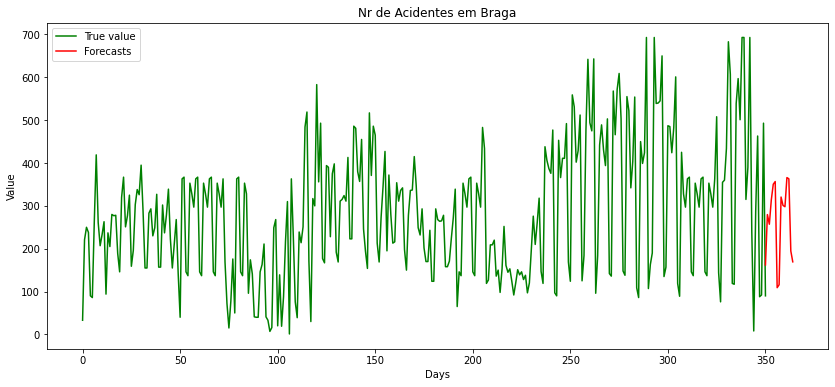

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
10/10 [==============================] - 3s 132ms/step - loss: 0.2987 - mae: 0.2506 - rmse: 0.2993 - val_loss: 0.2797 - val_mae: 0.2423 - val_rmse: 0.2797
Epoch 2/120
10/10 [==============================] - 0s 15ms/step - loss: 0.2397 - mae: 0.2152 - rmse: 0.2404 - val_loss: 0.4067 - val_mae: 0.3499 - val_rmse: 0.4067
Epoch 3/120
10/10 [============================

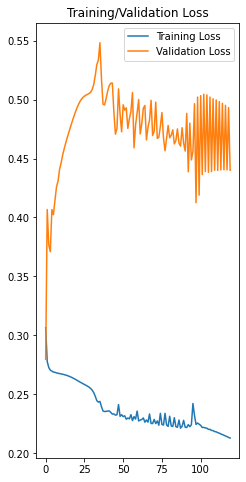

Epoch 1/120
20/20 [==============================] - 0s 14ms/step - loss: 0.3196 - mae: 0.2574 - rmse: 0.3073 - val_loss: 0.2123 - val_mae: 0.1794 - val_rmse: 0.2123
Epoch 2/120
20/20 [==============================] - 0s 12ms/step - loss: 0.2872 - mae: 0.2349 - rmse: 0.2752 - val_loss: 0.2207 - val_mae: 0.1835 - val_rmse: 0.2207
Epoch 3/120
20/20 [==============================] - 0s 11ms/step - loss: 0.2842 - mae: 0.2354 - rmse: 0.2720 - val_loss: 0.2213 - val_mae: 0.1828 - val_rmse: 0.2213
Epoch 4/120
20/20 [==============================] - 0s 13ms/step - loss: 0.2838 - mae: 0.2349 - rmse: 0.2720 - val_loss: 0.2218 - val_mae: 0.1846 - val_rmse: 0.2218
Epoch 5/120
20/20 [==============================] - 0s 12ms/step - loss: 0.2844 - mae: 0.2353 - rmse: 0.2731 - val_loss: 0.2254 - val_mae: 0.1889 - val_rmse: 0.2254

Epoch 00005: val_loss improved from 0.40669 to 0.22537, saving model to my_model_5_0.225.h5
Epoch 6/120
20/20 [==============================] - 0s 12ms/step - loss: 0.2

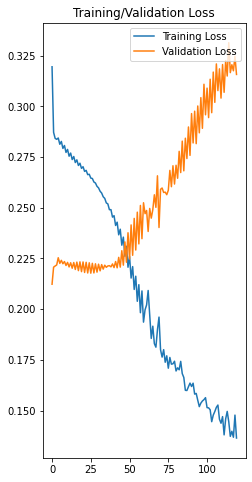

Epoch 1/120
29/29 [==============================] - 0s 13ms/step - loss: 0.1909 - mae: 0.1560 - rmse: 0.1930 - val_loss: 0.4400 - val_mae: 0.3506 - val_rmse: 0.4064
Epoch 2/120
29/29 [==============================] - 0s 11ms/step - loss: 0.2017 - mae: 0.1664 - rmse: 0.2033 - val_loss: 0.3974 - val_mae: 0.3183 - val_rmse: 0.4001
Epoch 3/120
29/29 [==============================] - 0s 11ms/step - loss: 0.1826 - mae: 0.1484 - rmse: 0.1846 - val_loss: 0.3872 - val_mae: 0.3200 - val_rmse: 0.3581
Epoch 4/120
29/29 [==============================] - 0s 11ms/step - loss: 0.1782 - mae: 0.1448 - rmse: 0.1800 - val_loss: 0.3889 - val_mae: 0.3129 - val_rmse: 0.3622
Epoch 5/120
29/29 [==============================] - 0s 10ms/step - loss: 0.1788 - mae: 0.1467 - rmse: 0.1807 - val_loss: 0.4037 - val_mae: 0.3283 - val_rmse: 0.4079

Epoch 00005: val_loss did not improve from 0.21825
Epoch 6/120
29/29 [==============================] - 0s 11ms/step - loss: 0.1796 - mae: 0.1474 - rmse: 0.1814 - val_lo

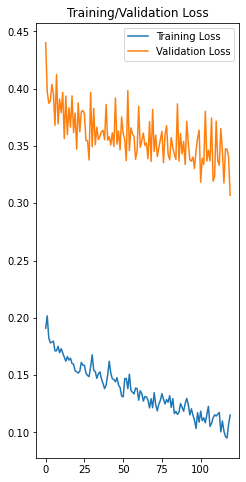

[array([[115.45047]], dtype=float32), array([[200.60078]], dtype=float32), array([[180.44403]], dtype=float32), array([[228.28185]], dtype=float32), array([[192.82979]], dtype=float32), array([[342.62753]], dtype=float32), array([[290.94928]], dtype=float32), array([[238.0507]], dtype=float32), array([[273.20346]], dtype=float32), array([[341.71094]], dtype=float32), array([[173.9928]], dtype=float32), array([[150.66776]], dtype=float32), array([[249.1316]], dtype=float32), array([[285.57822]], dtype=float32), array([[324.1317]], dtype=float32)]
[115.45047, 200.60078, 180.44403, 228.28185, 192.82979, 342.62753, 290.94928, 238.0507, 273.20346, 341.71094, 173.9928, 150.66776, 249.1316, 285.57822, 324.1317]


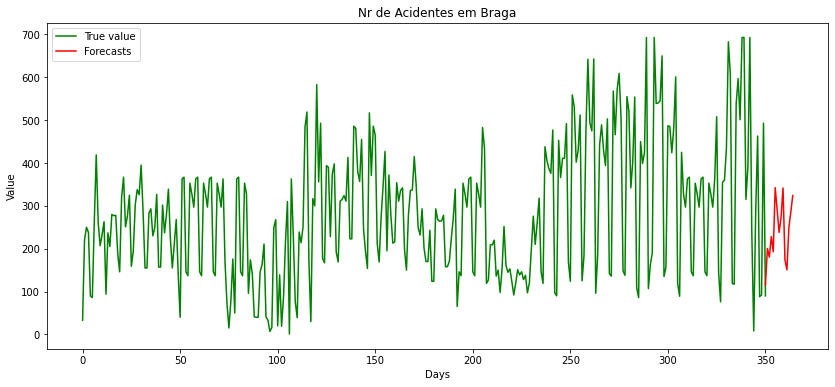

In [ ]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [ ]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [ ]:
for f in final_dict:
  print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
  print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.28065317173798876, 0.24158202360073724, 0.2821647753318151, 0.34050278911987936, 0.29289254794518155, 0.3361673131585121] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.23855353464682896, 0.2008068589369456, 0.23992189437150957, 0.35743318349123004, 0.31848497549692795, 0.36020494083563487] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.20974549079934757, 0.17498556536932786, 0.21075706789890924, 0.38229093457261726, 0.34466368521253266, 0.3880490855375926] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.23409768640995024, 0.19993335588110817, 0.23344482315911186, 0.3714453528324763, 0.3221807656188806, 0.3739573804868592] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.21247361142326285, 0.1803403875342122, 0.21184012939532595, 0.3770365022950703, 0.3264849860911016, 0.382693

In [ ]:
pd.DataFrame.from_dict(final_dict, orient='index',columns=['Loss', 'MAE', 'RMSE', 'VAL_LOSS', 'VAL_MAE', 'VAL_RMSE'])

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.280653,0.241582,0.282165,0.340503,0.292893,0.336167
2,0.238554,0.200807,0.239922,0.357433,0.318485,0.360205
3,0.209745,0.174986,0.210757,0.382291,0.344664,0.388049
4,0.234098,0.199933,0.233445,0.371445,0.322181,0.373957
5,0.212474,0.180340,0.211840,0.377037,0.326485,0.382694
6,0.188363,0.160353,0.188165,0.365361,0.322816,0.368871
7,0.260591,0.220651,0.257261,0.372275,0.326069,0.384659
8,0.226227,0.189321,0.221887,0.354089,0.304836,0.340699
9,0.194605,0.161093,0.191511,0.362588,0.317034,0.357881
